In [1]:
#https://github.com/vinuthags/adversarial_attack
#https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
%matplotlib inline

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils


In [16]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)


X_train original shape (60000, 28, 28)
y_train original shape (60000,)


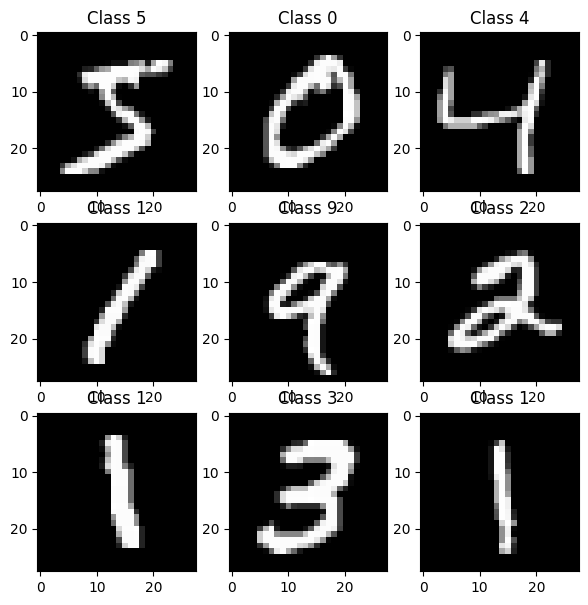

In [17]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))


In [18]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)


Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [19]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


In [20]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) # An "activation" is just a non-linear function applied to the output
                              # of the layer above. Here, with a "rectified linear unit",
                              # we clamp all values below 0 to 0.

model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # This special "softmax" activation among other things,
                                 # ensures the output is a valid probaility distribution, that is
                                 # that its values are all non-negative and sum to 1.

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [22]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=4, verbose=1,
          validation_data=(X_test, Y_test))


Epoch 1/4
469/469 [==============================] - 10s 18ms/step - loss: 0.2498 - accuracy: 0.9248 - val_loss: 0.1202 - val_accuracy: 0.9618

In [23]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.06452738493680954
Test accuracy: 0.9790999889373779


In [24]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]


313/313 [==============================] - 2s 6ms/step

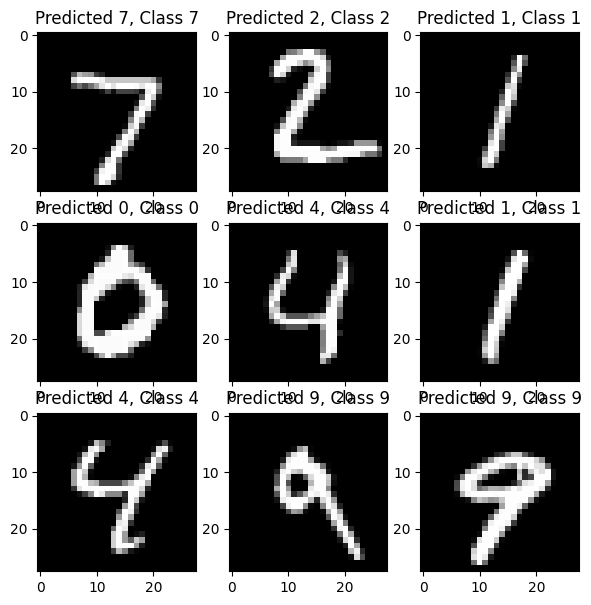

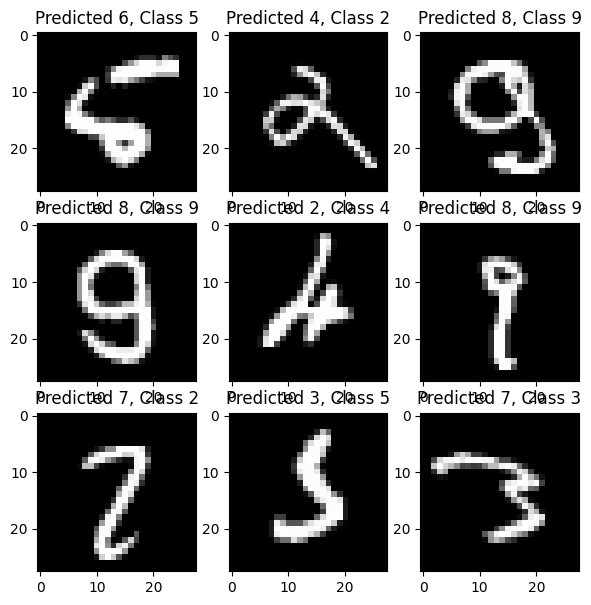

In [25]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))


Text(0.5, 1.0, 'Пример наложения на 7')

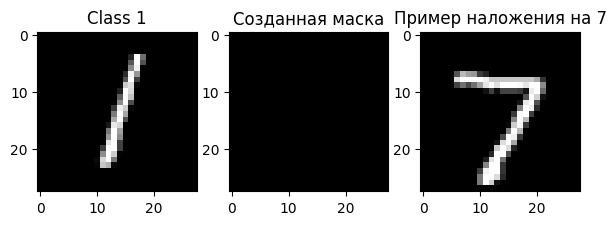

In [37]:
imask = 2
eps = 0.3
noise_coef = 0.5
iex = 0
r_noise = np.random.rand(np.shape(X_test)[1],)
mask = np.sign(X_test[imask] + r_noise * noise_coef ) * eps
plt.subplot(1,3,1)
plt.imshow(X_test[imask].reshape(28,28), cmap='gray', interpolation='none')
plt.title("Class {}".format(y_test[imask]))
plt.subplot(1,3,2)
plt.imshow(mask.reshape(28,28), cmap='gray', interpolation='none')
plt.title("Созданная маска")
plt.subplot(1,3,3)
plt.imshow((mask+X_test[iex]).reshape(28,28), cmap='gray', interpolation='none')
plt.title("Пример наложения на {}".format(y_test[iex]))


In [38]:
xtstx = X_test[correct_indices]
ytsty = y_test[correct_indices]
for i in range(np.shape(xtstx)[0]):
    xtstx[i] =  xtstx[i] + mask
pc = np.argmax(model.predict(xtstx), axis=-1)

# Check which items we got right / wrong
corInd = np.nonzero(pc == ytsty)[0]
incInd = np.nonzero(pc != ytsty)[0]
print('неправильно определено',np.size(incInd))
print('правильно определено',np.size(corInd))

306/306 [==============================] - 2s 7ms/step

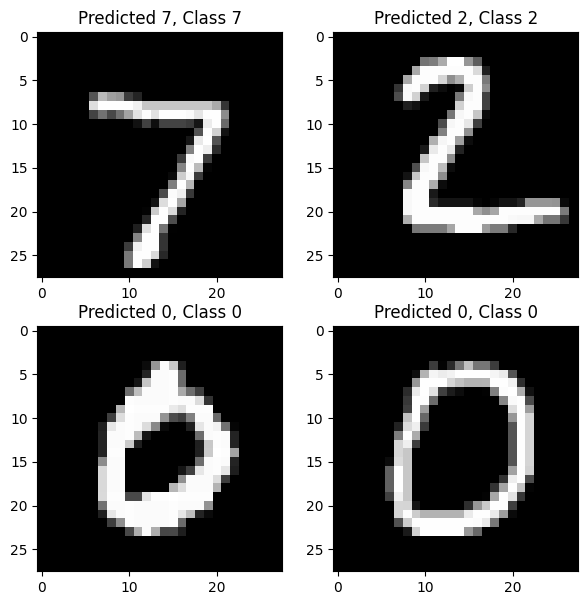

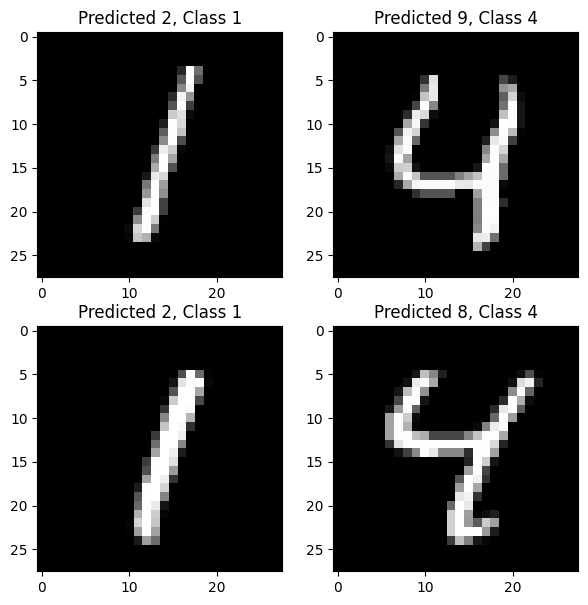

In [39]:
plt.figure()
for i, correct in enumerate(corInd[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(xtstx[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pc[correct], ytsty[correct]))

plt.figure()
for i, incorrect in enumerate(incInd[:4]):
    plt.subplot(2,2,i+1)
    plt.imshow(xtstx[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pc[incorrect], ytsty[incorrect]))

In [ ]:
'''
распределение по каждому классу
готовая реализация на resnet обученной на imagenet тоже случайную маску
как работает на рентгенах грудной клетке
поиграться с количеством слоев
и оценить
мат обоснование
'''